In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# 1. 加載數據
data = pd.read_csv("C:/Users/user/Desktop/ML/Final/BMW_Data.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
# 計算平均真實範圍 (ATR)
def calculate_atr(data, n=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=n).mean()
    return atr

def KNNWeights(X):
    # Step 1: 加上小常數防止除零
    X = X + 1e-8
    
    # Step 2: 計算倒數並標準化
    X = (1 / X) / np.sum(1 / X)
    
    # Step 3: 返回結果
    return X

In [5]:
# 2. 特徵工程
window_size = 3  # 滾動窗口大小
for i in range(1, window_size + 1):
    data[f'Close_t-{i}'] = data['Close'].shift(i)

# 計算 ATR 並加入數據
data['ATR'] = calculate_atr(data)
data.dropna(inplace=True)

# 目標值為下一天的收盤價
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# 分割特徵與目標
features = [col for col in data.columns if 'Close_t-' in col or col == 'ATR']
X = data[features]
y = data['Target']

# 3. 訓練與測試集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
y_train_diff = y_train.diff()

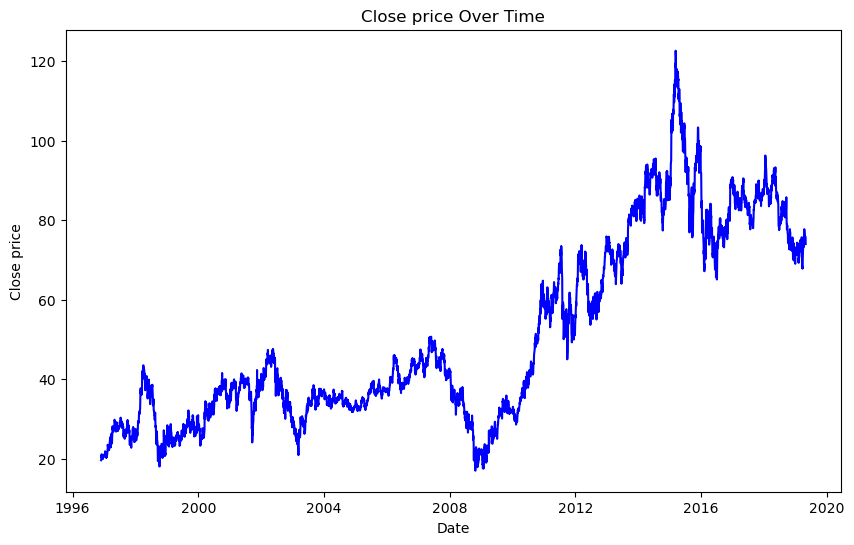

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, color='blue')  # 用 data.index 替代 data['Date']
plt.title('Close price Over Time')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

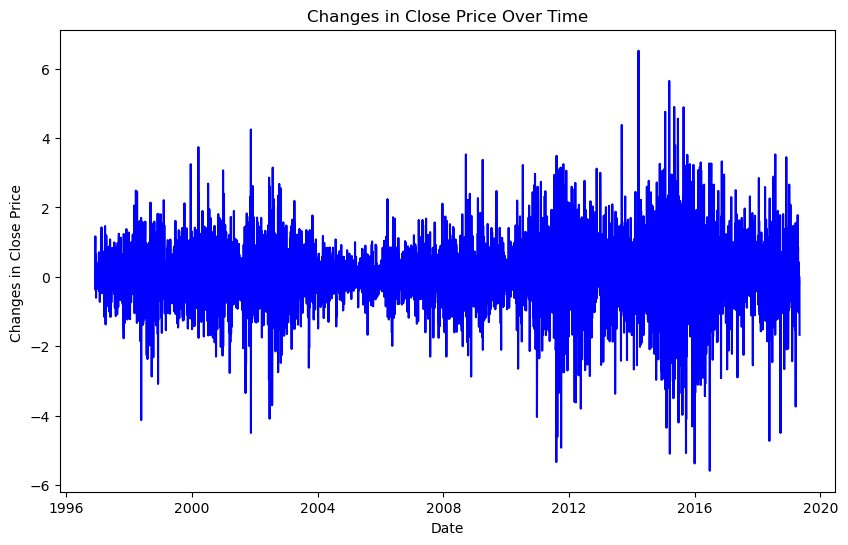

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train_diff, color='blue')  # 用 data.index 替代 data['Date']
plt.title('Changes in Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Changes in Close Price ')
plt.show()

In [60]:
data['Target'][0:5758]

Date
1996-11-27    19.667000
1996-11-28    19.691999
1996-11-29    19.992001
1996-12-02    21.158001
1996-12-03    21.028000
                ...    
2019-04-26    75.889999
2019-04-29    75.900002
2019-04-30    75.800003
2019-05-02    75.669998
2019-05-03    74.000000
Name: Target, Length: 5758, dtype: float64

In [73]:
predictions = []

# 滾動視窗的參數
d = 3  # 使用前 d 個數據
k = 26  # 最近鄰數量

for i in range(1440):  # 預測循環

    # 動態取數據
    y = data['Target'][0:5758 + i]
    y_diff = y.diff()
    N = len(y_diff)

    # 取目標值
    target = y_diff[(N - d):N].to_numpy().reshape(1, -1)

    # 計算距離
    distances = np.linalg.norm(
        y_diff[:(N - d)].to_numpy().reshape(-1, 1) - target, axis=1
    )

    # 找出 KNN 的索引
    KNN_Ind = np.argsort(distances)[:min(k, len(distances))]  # 限制 KNN 數量
    local_y = y_diff.iloc[KNN_Ind]

    # 加權處理 (距離越近權重越高)
    dis = distances[KNN_Ind]
    weights = 1 / (dis + 1e-5)  # 防止除以零
    weights /= weights.sum()

    # 預測值
    pred = y.iloc[N - 1] + np.sum(local_y.to_numpy() * weights)
    predictions.append(pred)

# 結果存於 predictions


In [74]:
# 5. 評估模型
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse:.2f}")

# 6. 保存結果
results = pd.DataFrame({
    'True': y_test.values,
    'Predicted': predictions
}, index=y_test.index)
results.to_csv("predictions_with_dynamic_k.csv")

print("Predictions saved to 'predictions_with_dynamic_k.csv'")

Test RMSE: 1.66
Predictions saved to 'predictions_with_dynamic_k.csv'


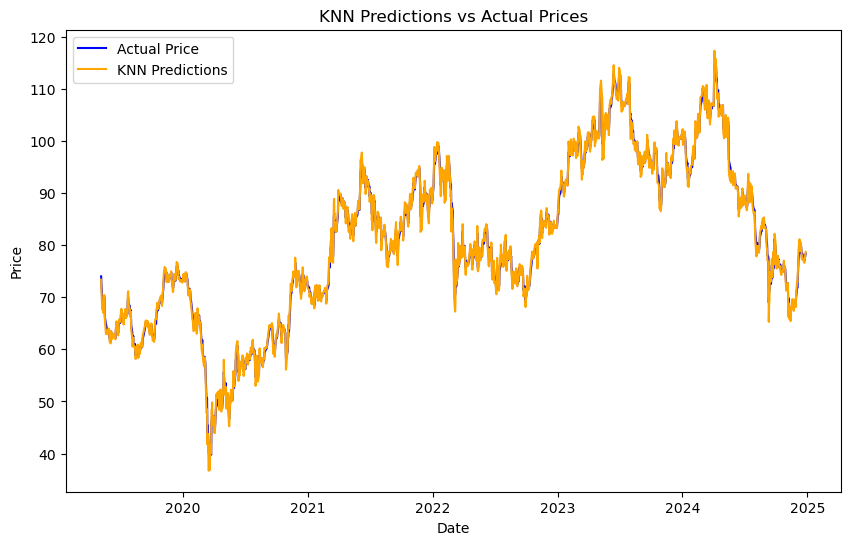

In [75]:
# 確保 predictions 長度與 data.index 對齊
if len(predictions) < len(data.index):
    aligned_data = data.iloc[-len(predictions):]  # 根據 predictions 長度裁剪 data
else:
    aligned_data = data

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(aligned_data.index, aligned_data['Close'], label='Actual Price', color='blue')
plt.plot(aligned_data.index, predictions, label='KNN Predictions', color='orange')
plt.title('KNN Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()